<a href="https://colab.research.google.com/github/ANS1514/Projects_in_AI-ML/blob/main/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from datasets import load_dataset

In [ ]:
# Load, Pre-process, and establish train/test
dataset = load_dataset("cnn_dailymail", "3.0.0")
dataset['train'] = dataset['train'].select(range(1000))
dataset['test'] = dataset['test'].select(range(200))

def preprocess_function(examples):
    inputs = [doc for doc in examples["article"]]
    targets = [summary for summary in examples["highlights"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)
    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

train_test_split = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_dataset = train_test_split["train"].map(preprocess_function, batched=True)
test_dataset = train_test_split["test"].map(preprocess_function, batched=True)

# Train Args
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    learning_rate=3e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# set Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
)


trainer.train()


C:\Users\anson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
500,2.643800,2.139530
1000,2.322400,2.065781
1500,1.882300,2.052562
2000,1.708800,2.061450
2500,1.468700,2.046364


C:\Users\anson\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=2700, training_loss=1.9686623241283276, metrics={'train_runtime': 429.6263, 'train_samples_per_second': 6.285, 'train_steps_per_second': 6.285, 'total_flos': 1106660953681920.0, 'train_loss': 1.9686623241283276, 'epoch': 3.0})

In [ ]:
import numpy as np
import evaluate


# Load metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

def generate_summary(batch):
    inputs = tokenizer(batch["article"], max_length=1024, truncation=True, padding="longest", return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=128, early_stopping=True)
    batch["predictions"] = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
    return batch

predictions = test_dataset.map(generate_summary, batched=True, batch_size=2)

preds = predictions["predictions"]
refs = [[ref] for ref in predictions["highlights"]]

# Compute BLEU and ROUGE scores
bleu_result = bleu_metric.compute(predictions=preds, references=refs)
rouge_result = rouge_metric.compute(predictions=preds, references=refs)

print("BLEU Score:", bleu_result["bleu"])
print("ROUGE Scores:", rouge_result)


Parameter 'function'=<function generate_summary at 0x000001E7CA7167A0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map: 100%|██████████| 100/100 [00:53<00:00,  1.88 examples/s]


BLEU Score: 0.10347868250945032
ROUGE Scores: {'rouge1': 0.3320281176305042, 'rouge2': 0.12424298375468185, 'rougeL': 0.2359958850367327, 'rougeLsum': 0.3109968944341098}


Analyze your results and discuss the impact of hyperparameters.
- The hyperparameter tuning was a tad difficult for my machine. I was running into a ton of memory errors with my GPU, I had to lower the batch size and be cautious of usage. 100% hyperparameter tuning may be achioeved with infinite computational power, I had to work with what I had avaliable and that may reflect in the final scores from rouge and bleu.
Are your results impacted by the choice of the LLM here? How?
- Yes they are impacted by the choice of LLM, nothing is 100% similar. So results may be similar between LLMs but always different to some degree. Whether it be different tokenization or handling of inputs. BART is suited for seq2seq tasks like summarization, unlike T5 or LLaMA which is inherently general purpose.

Task 2(20 points): We discussed how we can formulate RL problems as an MDP. Describe any
real-world application that can be formulated as an MDP. Describe the state space, action
space, transition model, and rewards for that problem. You do not need to be precise in the
description of the transition model and reward (no formula is needed). Qualitative description
is enough.

- An obvious example is the self driving car. This can easily be represented by the MDP, lets consider a self driving car at an intersection
- State Space
    - position
    - velocty
    - Traffic light status
    - Pedestrian proximity
    - Time spent waiting at light
    - car proximity
    - road lines
- Action Space
    - Drive
    - Reverse
    - Brake
    - Turn
    - Wait
- Transition Model
    - light green and car moving forward, results in the next stat in the middle of the intersection
    - Red light results in the car braking with lowering velocity
- Rewards
    - positive: sucessfully crossing / braking / not hitting another car / being between the lines of the road
    - Large Negative: hitting something
    - Small Negative: harsh braking / inbetween lanes / waiting too long to move/brake

Task 3(20 points): RL is used in various sectors - Healthcare, recommender systems and trading
are a few of those. Pick one of the three areas. Explain one of the problems in any of these
domains that can be more effectively solved by reinforcement learning. Find an open-source
project (if any) that has addressed this problem. Explain this project in detail.

https://github.com/BintaSOW1/Reinforcement-learning-for-healthcare-applications - Healthcare application for optimizaing treatment strategies for patients with sepsis in ICU

RL is used here as a solution to a sequential decison making problem where an agent recommends treatments based on patient condition. The project uses Q-learning to estimate the value of a treatment action in a given patient state and it trains a policy on historical ICU data to maximize long term health. The dataset is from MIMIC-III which is a large public ICU dataset. This was implemented to best catch the sequential and delayed nature of medical effects, finding the most optimal treatment for long term while sacrificing a little in the short term. This model is able to personalize treatment strategies based on patient specific features as well.

Task 5 (30 points): For this task use the MovieLens 100k dataset
(https://grouplens.org/datasets/movielens/100k/)
Perform the necessary data cleaning, EDA and conversion to User-item matrix.
Implement any 2 collaborative filtering recommendation systems (RecSys) algorithms covered
in class (Matrix Factorization, Alternating Least Squares, NCF etc.) and compare their
performance for any 2-evaluation metrics used for RecSys. You may read literature to find out
which evaluation metrics are used for RecSys. Cite all your research.

https://towardsdatascience.com/what-are-rmse-and-mae-e405ce230383/
https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54


In [ ]:
import pandas as pd

# Load ratings data
ratings = pd.read_csv("u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
ratings.drop("timestamp", axis=1, inplace=True)

# Load movies data
movies = pd.read_csv("u.item", sep="|", encoding="latin-1", header=None, usecols=[0, 1],
                     names=["item_id", "title"])

# Merge ratings with movie titles
ratings = ratings.merge(movies, on="item_id")


Number of users: 943
Number of movies: 1682


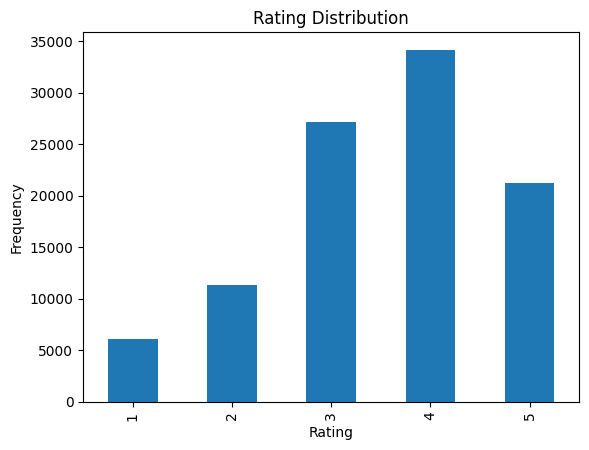

In [ ]:
import matplotlib.pyplot as plt

# Unique users/movies
num_users = ratings['user_id'].nunique()
num_movies = ratings['item_id'].nunique()
print(f"Number of users: {num_users}")
print(f"Number of movies: {num_movies}")

# Plot findings
ratings['rating'].value_counts().sort_index().plot(kind='bar', title="Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()


In [ ]:
from scipy.sparse import csr_matrix

user_item_matrix = ratings.pivot_table(index='user_id', columns='item_id', values='rating')
user_item_matrix.fillna(0, inplace=True)

# sparse matrix
interaction_matrix = csr_matrix(user_item_matrix.values)


In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# Prepare data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["user_id", "item_id", "rating"]], reader)

# SVD model using cross-validation
svd = SVD()
cv_results = cross_validate(svd, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

# Display metrics
print("SVD Evaluation Metrics:")
print(f"Average RMSE: {sum(cv_results['test_rmse'])/len(cv_results['test_rmse']):.4f}")
print(f"Average MAE: {sum(cv_results['test_mae'])/len(cv_results['test_mae']):.4f}")


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9255  0.9353  0.9353  0.9363  0.9426  0.9350  0.0055  
MAE (testset)     0.7323  0.7326  0.7373  0.7389  0.7430  0.7368  0.0040  
Fit time          0.79    0.86    0.83    0.79    0.84    0.82    0.03    
Test time         0.13    0.08    0.07    0.13    0.07    0.10    0.03    
SVD Evaluation Metrics:
Average RMSE: 0.9350
Average MAE: 0.7368


In [ ]:
import numpy as np
import scipy.sparse as sp
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import precision_at_k
from sklearn.model_selection import train_test_split

ratings['implicit_rating'] = 1

# Create an item-user matrix
item_user_matrix = ratings.pivot(index='item_id', columns='user_id', values='implicit_rating').fillna(0)
sparse_item_user = sp.csr_matrix(item_user_matrix.values)

n_users = sparse_item_user.shape[1]
train_user_indices, test_user_indices = train_test_split(np.arange(n_users), test_size=0.2, random_state=42)

train_user_items = sparse_item_user[:, train_user_indices]
test_user_items = sparse_item_user[:, test_user_indices]

# Train ALS on training data
als_model = AlternatingLeastSquares(factors=20, regularization=0.1, iterations=15)
als_model.fit(train_user_items)

# Evaluate using Precision@10
precision = precision_at_k(als_model, test_user_items, train_user_items, K=10)
print(f"ALS Precision@10: {precision:.4f}")


100%|██████████| 1635/1635 [00:00<00:00, 9207.14it/s]

ALS Precision@10: 0.7541
